# Comparison between the external depolarization tensor of an prolate ellipsoid and a sphere

This code presents an empirical validation of equation A4

In [1]:
from __future__ import division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import tri
from mesher import ProlateEllipsoid
import prolate_ellipsoid

from fatiando.gridder import scatter

from fatiando.mesher import Sphere
from fatiando.gravmag import sphere

C:\Users\Vanderlei\Documents\fatiando\fatiando\vis\mpl.py:70: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
def compare(x, y, z1, z2):
    triang = tri.Triangulation(x, y)
    
    ranges = np.max(np.abs([z1.min(), z1.max(),
                            z2.min(), z2.max()]))

    plt.close('all')
    plt.figure(figsize=(12, 3))
    plt.axis('equal')

    plt.subplot(1, 3, 1)
    plt.tricontourf(triang, z1, 20,
                    vmin=-ranges, vmax=ranges, cmap=plt.get_cmap('RdBu_r'))
    plt.colorbar()
    plt.tick_params(axis='x', labelbottom='off')
    plt.tick_params(axis='y', labelleft='off')

    plt.subplot(1, 3, 2)
    plt.tricontourf(triang, z2, 20,
                    vmin=-ranges, vmax=ranges, cmap=plt.get_cmap('RdBu_r'))
    plt.colorbar()
    plt.tick_params(axis='x', labelbottom='off')
    plt.tick_params(axis='y', labelleft='off')

    plt.subplot(1, 3, 3)
    plt.tricontourf(triang, z1 - z2, 20,
                    cmap=plt.get_cmap('RdBu_r'))
    plt.colorbar()
    plt.tick_params(axis='x', labelbottom='off')
    plt.tick_params(axis='y', labelleft='off')

    plt.tight_layout()

    plt.show()

In [3]:
ellipsoid = ProlateEllipsoid(0, 1000, 1000, 500.1, 499.9,
                             180*np.random.rand(), 90*np.random.rand(), 90*np.random.rand())

In [4]:
print ellipsoid.transf_matrix

[[-0.99009938  0.01742312 -0.13928262]
 [ 0.11641034  0.65637022 -0.74540376]
 [ 0.0784337  -0.75423774 -0.65189998]]


In [5]:
area = [-3000, 3000, -2000, 4000]
x, y, z = scatter(area, 300, z=0)

In [6]:
x1, x2, x3 = prolate_ellipsoid.x1x2x3(x, y, z, ellipsoid)
lamb = prolate_ellipsoid._lamb(x1, x2, x3, ellipsoid)
denominator = prolate_ellipsoid._dlamb_aux(x1, x2, x3, ellipsoid, lamb)
dlamb_dx = prolate_ellipsoid._dlamb(x1, x2, x3, ellipsoid, lamb, denominator, deriv='x')
dlamb_dy = prolate_ellipsoid._dlamb(x1, x2, x3, ellipsoid, lamb, denominator, deriv='y')
dlamb_dz = prolate_ellipsoid._dlamb(x1, x2, x3, ellipsoid, lamb, denominator, deriv='z')
h1 = prolate_ellipsoid._hv(ellipsoid, lamb, v='x')
h2 = prolate_ellipsoid._hv(ellipsoid, lamb, v='y')
h3 = prolate_ellipsoid._hv(ellipsoid, lamb, v='z')
g1 = prolate_ellipsoid._gv(ellipsoid, lamb, v='x')
g2 = prolate_ellipsoid._gv(ellipsoid, lamb, v='y')
g3 = prolate_ellipsoid._gv(ellipsoid, lamb, v='z')

a = ellipsoid.large_axis
b = ellipsoid.small_axis
volume = 4*np.pi*a*b*b/3
cte = -1.5*volume

In [7]:
# elements of the depolarization tensor without the ellipsoid in the local system
nxx_tilde = cte*(dlamb_dx*h1*x1 + g1)
nxy_tilde = cte*(dlamb_dx*h2*x2)
nxz_tilde = cte*(dlamb_dx*h3*x3)
nyy_tilde = cte*(dlamb_dy*h2*x2 + g2)
nyz_tilde = cte*(dlamb_dy*h3*x3)
nzz_tilde = cte*(dlamb_dz*h3*x3 + g3)

In [8]:
# elements of the depolarization tensor without the ellipsoid in the main system
n_tilde = np.array([nxx_tilde, nxy_tilde, nxz_tilde,
                    nxy_tilde, nyy_tilde, nyz_tilde,
                    nxz_tilde, nyz_tilde, nzz_tilde]).T
n_tilde = np.reshape(n_tilde, (nxx_tilde.size, 3, 3))

nxx = []
nxy = []
nxz = []
nyy = []
nyz = []
nzz = []

for nti in n_tilde:
    nxx.append(np.dot(ellipsoid.transf_matrix[0,:], np.dot(nti, ellipsoid.transf_matrix[0,:])))
    nxy.append(np.dot(ellipsoid.transf_matrix[0,:], np.dot(nti, ellipsoid.transf_matrix[1,:])))
    nxz.append(np.dot(ellipsoid.transf_matrix[0,:], np.dot(nti, ellipsoid.transf_matrix[2,:])))
    nyy.append(np.dot(ellipsoid.transf_matrix[1,:], np.dot(nti, ellipsoid.transf_matrix[1,:])))
    nyz.append(np.dot(ellipsoid.transf_matrix[1,:], np.dot(nti, ellipsoid.transf_matrix[2,:])))
    nzz.append(np.dot(ellipsoid.transf_matrix[2,:], np.dot(nti, ellipsoid.transf_matrix[2,:])))

nxx = np.array(nxx)
nxy = np.array(nxy)
nxz = np.array(nxz)
nyy = np.array(nyy)
nyz = np.array(nyz)
nzz = np.array(nzz)

In [9]:
sphere_fat = Sphere(ellipsoid.x, ellipsoid.y, ellipsoid.z,
                    0.5*(ellipsoid.large_axis + ellipsoid.small_axis))

In [10]:
kxx = sphere.kernelxx(x, y, z, sphere_fat)
kxy = sphere.kernelxy(x, y, z, sphere_fat)
kxz = sphere.kernelxz(x, y, z, sphere_fat)
kyy = sphere.kernelyy(x, y, z, sphere_fat)
kyz = sphere.kernelyz(x, y, z, sphere_fat)
kzz = sphere.kernelzz(x, y, z, sphere_fat)

C:\Program Files\Anaconda2\lib\site-packages\matplotlib\tri\triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


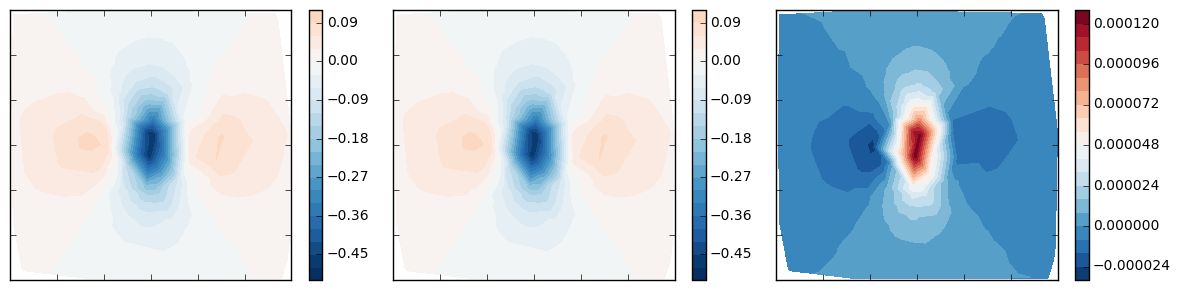

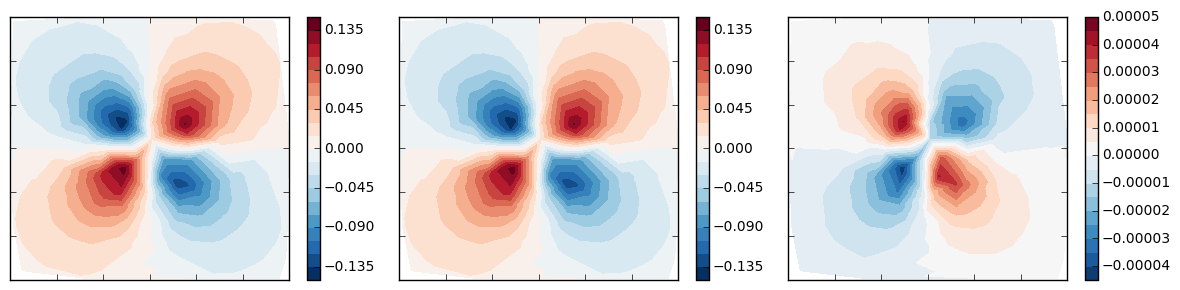

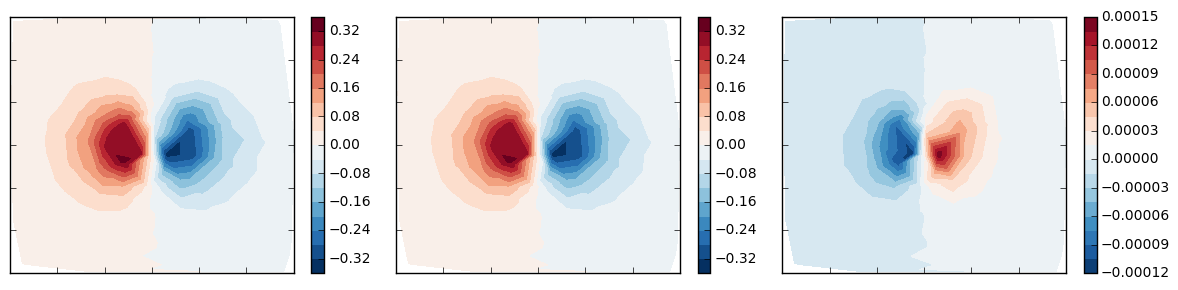

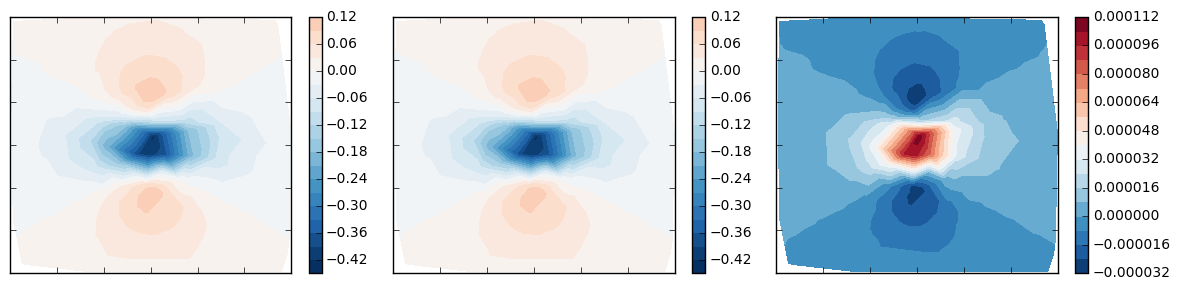

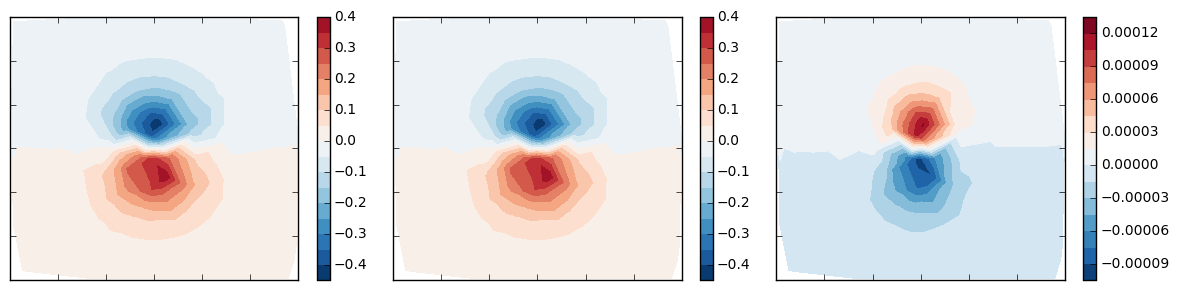

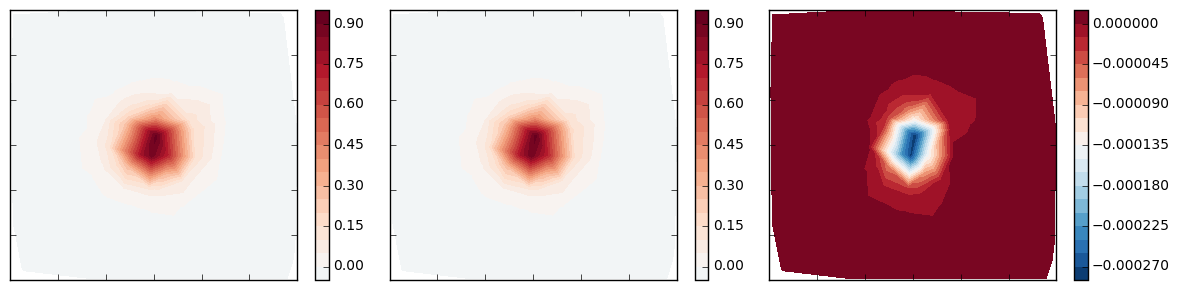

In [11]:
compare(x, y, nxx, kxx)
compare(x, y, nxy, kxy)
compare(x, y, nxz, kxz)
compare(x, y, nyy, kyy)
compare(x, y, nyz, kyz)
compare(x, y, nzz, kzz)